In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.integrate import quad
from scipy.optimize import brentq, least_squares
import matplotlib.pylab as plt
import math
import warnings
from scipy.integrate import IntegrationWarning

warnings.filterwarnings("ignore", category=IntegrationWarning)

In [2]:
# Preprocessing and BS supporting funcs
def impliedVolatility(S, K, r, price, T, payoff):
    try:
        if (payoff.lower() == 'call'):
            impliedVol = brentq(lambda x: price -
                                BlackScholesLognormalCall(S, K, r, x, T),
                                1e-12, 10.0)
        elif (payoff.lower() == 'put'):
            impliedVol = brentq(lambda x: price -
                                BlackScholesLognormalPut(S, K, r, x, T),
                                1e-12, 10.0)
        else:
            raise NameError('Payoff type not recognized')
    except Exception:
        impliedVol = np.nan

    return impliedVol

def preprocess_options_data(file_path):
    """
    Preprocess options data by calculating mid-price, scaling strike prices, 
    and mapping call/put flags.

    Parameters:
    - file_path (str): Path to the CSV file containing options data.

    Returns:
    - DataFrame: Processed options data with 'mid', 'strike', and 'payoff' columns.
    """
    df = pd.read_csv(file_path)
    df['mid'] = 0.5 * (df['best_bid'] + df['best_offer'])
    df['strike'] = df['strike_price'] * 0.001  # Adjusting strike price scale
    df['payoff'] = df['cp_flag'].map(lambda x: 'call' if x == 'C' else 'put')
    return df

def BlackScholesLognormalCall(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

def BlackScholesLognormalPut(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

def BachelierCall(S0, K, T, r, sig)->tuple:
    """
    Calculate the discounted Bachelier prices of European call options.
    """
    d = (S0 - K)/(sig*T**.5)
    
    return math.exp(-r*T) * ( (S0 - K)*norm.cdf( d) + sig*T**.5*norm.pdf( d))

def BachelierPut(S0, K, T, r, sig)->tuple:
    """
    Calculate the discounted Bachelier prices of European put options.
    """
    d = (S0 - K)/(sig*T**.5)
    
    return math.exp(-r*T) * (-(S0 - K)*norm.cdf(-d) + sig*T**.5*norm.pdf(-d))

def SABR(F, K, T, alpha, beta, rho, nu):
    """
    Use SABR model to return sigma 
    """

    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom

    return sabrsigma

In [3]:
# Read data and instantiate constants
df_rates = pd.read_csv("zero_rates_20201201.csv")\
            .sort_values('days')
df_spx = preprocess_options_data("SPX_options.csv")
df_spy = preprocess_options_data("SPY_options.csv")

exdate = 20210115                       # contract expiry to use
days_to_expiry = (pd.Timestamp(str(exdate)) - pd.Timestamp('2020-12-01')).days
r = np.interp(days_to_expiry, df_rates['days'].values, df_rates['rate'].values) / 100
T = days_to_expiry / 365
S_spx, K_spx = 3662.45, 3660
S_spy, K_spy= 366.02, 366

F_spx, F_spy = S_spx * np.exp(r * T), S_spy * np.exp(r * T)

# SABR constants
beta = 0.7
dict_spx = {'ticker': 'SPX', 
            'S': S_spx,
            'F': F_spx, 
            'K': K_spx, 
            'alpha': 1.8165044218295023, 
            'rho': -0.4043017619125521, 
            'nu': 2.7901583381061568}
dict_spy = {'ticker': 'SPY', 
            'S': S_spy,
            'F': F_spy, 
            'K': K_spy,
            'alpha': 0.9081326360891961, 
            'rho': -0.4887794505604543, 
            'nu': 2.7285163399809482}

# calculate get ATM params
df_spx_atm = df_spx[(df_spx['exdate']==exdate)& \
                    (df_spx['strike']==K_spx)& \
                    (df_spx['payoff']=='put')]
df_spy_atm = df_spy[(df_spy['exdate']==exdate)& \
                    (df_spy['strike']==K_spy)& \
                    (df_spy['payoff']=='put')]

# QF620 Project Part 3
Suppose on 1-Dec-2020, we need to evaluate an exotic European derivative
expiring on 15-Jan-2021
## 1. Contract Payoff function
Payoff function is

$$
S^{\frac{1}{3}}_T + 1.5 \times \log(S_T) + 10.0

$$


### 1.1 Black-Scholes Model
under Black-Scholes

$$
S_T = S_0 e^{(r - \frac{\sigma^2}{2})T + \sigma W_T}

$$

Therefore

$$
\begin{aligned}

V_0 
&= e^{-rT} \mathbb{E}
\left[
    {S_0^\frac{1}{3} e^{\frac{1}{3} (r - \frac{\sigma^2}{2})T + \frac{1}{3} \sigma W_T}}
    + 1.5 \times \log(S_0 e^{(r - \frac{\sigma^2}{2})T 
    + \sigma W_T}) + 10.0
\right] \\
&= 
e^{-rT}
\left[
{S_0^\frac{1}{3} e^{\frac{1}{3} (r - \frac{\sigma^2}{2})T}} \mathbb{E}[{e^{\frac{1}{3} \sigma W_T}}] +

	 1.5 \left[ 
		 \log{S_0} + \left(r - \frac{\sigma^2}{2} \right) T  + \mathbb{E}[\sigma W_T] 
	\right]
	+
	10.0
\right]
\\\\
V_0
&= 
e^{-rT}
\left[
{S_0^\frac{1}{3} e^{\frac{1}{3} (r - \frac{\sigma^2}{3})T}} +

	 1.5 \left[ 
		 \log{S_0} + \left(r - \frac{\sigma^2}{2} \right) T 
	\right]
	+
	10.0
\right]
\\

\end{aligned}
$$


#### 1.1.1 $\sigma$ used
There is many market implied volatilities 
We can try using ATM strike volatility $K = S_0$


In [4]:
dict_spx['bs_sigma'] = impliedVolatility(S_spx, K_spx, r, df_spx_atm['mid'].values[0], T, 'put')
dict_spy['bs_sigma'] = impliedVolatility(S_spy, K_spy, r, df_spy_atm['mid'].values[0], T, 'put')

print(10*"=", " Black-Scholes ", 10*"=")
print(f"SPX ATM implied vol: {dict_spx['bs_sigma']:.5f}")
print(f"SPY ATM implied vol: {dict_spy['bs_sigma']:.5f}")

==========  Black-Scholes  ==========
SPX ATM implied vol: 0.18886
SPY ATM implied vol: 0.19777



#### 1.1.2 Valuation
##### Method 1 - Analytical

In [5]:
spx_bs_px = np.exp(-r * T) *\
    (
        dict_spx['S'] **(1/3) * np.exp(1/3 * (r - (dict_spx['bs_sigma']**2) / 3) * T) \
        + 1.5 * (np.log(S_spx) + (r - (dict_spx['bs_sigma']**2) / 2) * T)
        + 10
	)

spy_bs_px = np.exp(-r * T) *\
    (
        dict_spy['S']**(1/3) * np.exp(1/3 * (r - (dict_spy['bs_sigma']**2) / 3) * T) \
        + 1.5 * (
                np.log(S_spy) 
                + (r - (dict_spy['bs_sigma']**2) / 2) * T)
        + 10
	)

print(10*"=", " Black-Scholes ", 10*"=")
print(f"SPX: Black-Scholes Price ${spx_bs_px:.2f}")
print(f"SPY: Black-Scholes Price ${spy_bs_px:.2f}")

==========  Black-Scholes  ==========
SPX: Black-Scholes Price $37.70
SPY: Black-Scholes Price $25.99


##### Method 2 - Monte Carlo 

In [6]:
print(10*"=", " Black - Scholes estimated price of contract ", 10*"=")

for d in [dict_spx, dict_spy]:
    num_simulations = 10**8  # Number of Monte Carlo simulations
    
    # Simulate end prices S_T under BS
    Z = np.random.normal(0, 1, num_simulations)
    S_T = d['S'] * np.exp((r - (d['bs_sigma']**2) / 2) * T - d["bs_sigma"] * np.sqrt(T) * Z )

    # Calculate payoff for each simulated S_T
    payoffs = S_T**(1/3) + 1.5 * np.log(S_T) + 10

    # Discount the expected payoff
    discounted_payoff = np.exp(-r * T) * np.mean(payoffs)
    
    print(f"{d['ticker']}:  ${discounted_payoff:.2f}")

==========  Black - Scholes estimated price of contract  ==========
SPX:  $37.70
SPY:  $25.99



### 1.2 Bachelier Model

$$
dS_T = \mu dt + \sigma dW_t
$$
$$
S_T = S_0 + \mu T + \sigma W_T
$$


#### 1.2.1 $\sigma$ used


In [7]:
dict_spx['bach_sigma'] = brentq(lambda x: df_spx_atm['mid'] \
                                        - BachelierCall(dict_spx['S'], 
                                                        dict_spx['K'] , 
                                                        T, r, x),
                                1e-12, 1000)
dict_spy['bach_sigma'] = brentq(lambda x: df_spy_atm['mid'] \
                                        - BachelierCall(dict_spy['S'], 
                                                        dict_spy['K'],
                                                        T, r, x),
                                1e-12, 1000)
print(10*"=", " Bachelier ATM implied vol ", 10*"=")
print(f"{dict_spx['ticker']}: {dict_spx['bach_sigma']:.2f}")
print(f"{dict_spy['ticker']}: {dict_spy['bach_sigma']:.2f}")

==========  Bachelier ATM implied vol  ==========
SPX: 670.65
SPY: 71.91



#### 1.2.2 Valuation


==========  Bachelier estimated price via Monte Carlo ==========
SPX: $37.70
SPY: $25.99


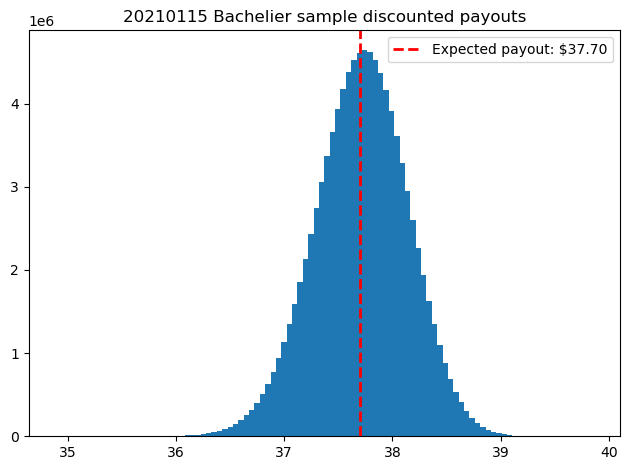

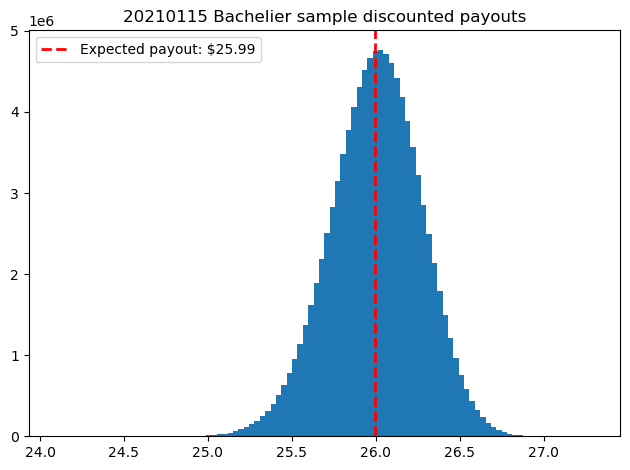

In [8]:
print(10*"=", " Bachelier estimated price via Monte Carlo", 10*"=")
num_simulations = 10**8  # Number of Monte Carlo simulations

for d in [dict_spx, dict_spy]:     
    Z = np.random.normal(0, 1, num_simulations)
    S_T = d['S'] + r * T + d['bach_sigma'] * np.sqrt(T) * Z

    # Calculate payoff for each simulated S_T
    bach_payoffs = S_T**(1/3) + 1.5 * np.log(S_T) + 10.0
    # Discount the expected payoff
    bach_discounted_payoff = np.exp(-r * T) * np.mean(bach_payoffs)

    print(f"{d['ticker']}: ${bach_discounted_payoff:.2f}")
    plt.figure(tight_layout=True)
    plt.title(f"{exdate} Bachelier sample discounted payouts")
    plt.hist(bach_payoffs, bins=100)
    plt.axvline(bach_discounted_payoff, color='red', 
                linestyle='dashed', linewidth=2, 
                label=f'Expected payout: ${bach_discounted_payoff:.2f}')
    plt.legend()
    
plt.show();


### 1.2 Static Replication of European Payoff Model
*using SABR model calibrated from Part 2*


##### Carr-Madan Static Replication formula
$$
V_0 = e^{-rT} h(F) + \int_{0}^{F} h''(K) P(K) \, dK + \int_{F}^{\infty} h''(K) C(K) \, dK
$$
#### 1.2.1 Calibrated SABR model
SPX: Exdate 20210115: alpha = 1.817, rho = -0.404, nu = 2.790

SPY: Exdate 20210115: alpha = 0.908, rho = -0.489, nu = 2.729
#### 1.2.2 Valuation
$$
S^{1/3}_T + 1.5 \times \log(S_T) + 10.0
$$
$$
h'(S_T) = \frac{1}{3} {S_T}^{-\frac{2}{3}} + 1.5 \frac{1}{S_T} \quad h''(S_T) = -\frac{2}{9} {S_T}^{-\frac{5}{3}} - 1.5 \frac{1}{{S_T}^2}
$$

$$

V_0 
= 
e^{-rT} \left[ K^{\frac{1}{3}} + 1.5 \times \log(K) + 10.0 \right]
    + \int_{0}^{F} \left( -\frac{2}{9} {K}^{-\frac{5}{3}} - 1.5 \frac{1}{{K}^2} \right) P(K) dK
        + \int_{F}^{\infty} \left( -\frac{2}{9} {K}^{-\frac{5}{3}} - 1.5 \frac{1}{{K}^2} \right) C(K) dK

$$



In [9]:
# Static replication supporting functions for special payout
def BlackScholesCall(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)


def BlackScholesPut(S, K, r, sigma, T):
    return BlackScholesCall(S, K, r, sigma, T) - S + K*np.exp(-r*T)

def SABRCall(S, K, r, alpha, beta, rho, nu, T):
    sabr_vol = SABR(S*np.exp(r*T), K, T, alpha, beta, rho, nu)
    return BlackScholesCall(S, K, r, sabr_vol, T)


def SABRPut(S, K, r, alpha, beta, rho, nu, T):
    sabr_vol = SABR(S*np.exp(r*T), K, T, alpha, beta, rho, nu)
    return BlackScholesPut(S, K, r, sabr_vol, T)

def h_double_prime(K):
    h_pp = -2 / 9*K**(-5/3) - 1.5 / (K**2)
    return h_pp

def P1_sabrcallintegrand(K, S, r, T, alpha, beta, rho, nu):
    """
    Function that incorporates integral h''(K) f(K) dK for call side
    """
    price = SABRCall(S, K, r, alpha, beta, rho, nu, T) * h_double_prime(K)
    return price


def P1_sabrputintegrand(K, S, r, T, alpha, beta, rho, nu):
    """
    Function that incorporates integral h''(K) f(K) dK for put side
    """
    price = SABRPut(S, K, r, alpha, beta, rho, nu, T) * h_double_prime(K)
    return price

In [10]:
print(10*"=", " Static Replication Model-Free estimated price via Monte Carlo", 10*"=")
num_simulations = 10**8  # Number of Monte Carlo simulations

for d in [dict_spx, dict_spy]: 
    I_put = quad(lambda x: P1_sabrputintegrand(x, 
                                            d['S'], 
                                            r, 
                                            T, 
                                            d['alpha'], 
                                            beta, 
                                            d['rho'], 
                                            d['nu']), 
                1e-6, 
                d['F'])
    I_call = quad(lambda x: P1_sabrcallintegrand(x, 
                                              d['S'],  
                                              r,
                                              T,
                                              d['alpha'],
                                              beta,
                                              d['rho'],
                                              d['nu']), 
                d['F'], 
                8000)
    E_v = np.exp(-r*T) * (d['S']**(1/3) + 1.5 * np.log(d['S']) + 10) + I_put + I_call
    print(f"{d['ticker']}: ${E_v[0]:.2f}")


==========  Static Replication Model-Free estimated price via Monte Carlo ==========
SPX: $37.70
SPY: $25.99



## 2. Variance Swap
Variance swaps are contracts which allow us to gain explicit volatility (and
variance) exposure. This frees us from the need to worry about delta or gamma
hedging if we were to use vanilla options to gain volatility exposure.
The payoff of a variance swap is given by
Var Swap = Notional × $(\sigma_R^2 − \sigma_K^2)$ ,
where σ2
R is the realized variance of the stock and σ2
K is the strike variance
$$

\mathbb{E} \left[ \int_0^T \sigma_t^2 \, dt \right] = 2 e^{rT} \int_0^F \frac{P(K)}{K^2} \, dK + 2 e^{rT} \int_F^{\infty} \frac{C(K)}{K^2} \, dK

$$
### 2.1 Black-Scholes Model
#### 2.1.1 $\sigma$ used
Use At-the-money Sigma

In [11]:
print(10*"=", " Black-Scholes expected ATM variance ", 10*"=")
for d in [dict_spx, dict_spy]:
    print(f"{d['ticker']}: {d['bs_sigma']:.5f}")

==========  Black-Scholes expected ATM variance  ==========
SPX: 0.18886
SPY: 0.19777



#### 2.1.2 Valuation


In [12]:
# Supporting funcs for Black-Scholes Variance swap pricing
def BlackScholesCall(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

def BlackScholesPut(S, K, r, sigma, T):
    return BlackScholesCall(S, K, r, sigma, T) - S + K*np.exp(-r*T)

def BScallintegrand(K, S, r, T, sigma):
    price = BlackScholesCall(S, K, r, sigma, T) / K**2
    return price

def BSputintegrand(K, S, r, T, sigma):
    price = BlackScholesPut(S, K, r, sigma, T) / K**2
    return price

In [13]:
print(10*"=", " Black-Scholes expected integrated variance ", 10*"=")

for d in [dict_spx, dict_spy]:
    I_put = quad(lambda x: BSputintegrand(x, d['S'], r, T, d['bs_sigma']), 0.0, d['F'])
    I_call = quad(lambda x: BScallintegrand(x, d['S'], r, T, d['bs_sigma']), d['F'], 8000)
    E_var = 2*np.exp(r*T)*(I_put[0] + I_call[0])
    print(f"{d['ticker']}: {E_var:.9f}")

==========  Black-Scholes expected integrated variance  ==========
SPX: 0.004397450
SPY: 0.004821988



### 2.2 Bachelier Model
#### 2.2.1 $\sigma$ used
Use At-the-money Sigma

In [14]:
print(10*"=", " Bachelier ATM variance ", 10*"=")
for d in [dict_spx, dict_spy]:
    print(f"{d['ticker']}: {d['bach_sigma']:.2f}")

==========  Bachelier ATM variance  ==========
SPX: 670.65
SPY: 71.91


#### 2.2.2 Valuation

In [15]:
# Supporting funcs for Bachelier Variance swap pricing
def BachelierCall(K, S, r, T, sigma):
    d = ( S - K)/( sigma*T**.5)
    return math.exp(-r*T) * ( ( S - K)*norm.cdf( d) +  sigma*T**.5*norm.pdf( d))

def BachelierPut(K, S, r, T, sigma):
    d = ( S - K)/( sigma*T**.5)
    return math.exp(-r*T) * (-( S - K)*norm.cdf(-d) +  sigma*T**.5*norm.pdf(-d))

def Bachcallintegrand(K, S, r, T, sigma):
    price = BachelierCall(K, S, r, T, sigma) / K**2
    return price

def Bachputintegrand(K, S, r, T, sigma):
    price = BachelierPut(K, S, r, T, sigma) / K**2
    return price

In [16]:
print(10*"=", " Bachelier expected integrated variance ", 10*"=")

for d in [dict_spx, dict_spy]:
    I_put = quad(lambda x: Bachputintegrand(x, d['S'], r, T, d['bach_sigma']), 0.0, d['F'])
    I_call = quad(lambda x: Bachcallintegrand(x, d['S'], r, T, d['bach_sigma']), d['F'], 8000)
    E_var_bach = 2*np.exp(r*T)*(I_put[0] + I_call[0])
    print(f"{d['ticker']}: {E_var_bach:.9f}")

==========  Bachelier expected integrated variance  ==========
SPX: 0.004160098
SPY: 0.004792845


### 2.2 Static Replication of European Payoff Model
*using SABR model calibrated from Part 2*

#### 2.2.1 Calibrated SABR model


In [17]:
print(10*"=", " SABR params ", 10*"=")
for d in [dict_spx, dict_spy]:
    print(f"{d['ticker']}:")
    print(f"\t alpha \t {d['alpha']:.4f}")
    print(f"\t beta \t {beta:.4f}")
    print(f"\t rho \t {d['rho']:.3f}")
    print(f"\t nu \t {d['nu']:.4f}")

==========  SABR params  ==========
SPX:
	 alpha 	 1.8165
	 beta 	 0.7000
	 rho 	 -0.404
	 nu 	 2.7902
SPY:
	 alpha 	 0.9081
	 beta 	 0.7000
	 rho 	 -0.489
	 nu 	 2.7285




#### 2.2.2 Valuation

In [24]:
# Supporting funcs for SABR Variancer Swap
def P2_sabrcallintegrand(K, S, r, T, alpha, beta, rho, nu):
    """
    Function that incorporates integral h''(K) f(K) dK for call side
    """
    price = SABRCall(S, K, r, alpha, beta, rho, nu, T) / (K**2)
    return price


def P2_sabrputintegrand(K, S, r, T, alpha, beta, rho, nu):
    """
    Function that incorporates integral h''(K) f(K) dK for put side
    """
    price = SABRPut(S, K, r, alpha, beta, rho, nu, T) / (K**2)
    return price

In [25]:
print(10*"=", " SABR expected integrated variance ", 10*"=")

for d in [dict_spx, dict_spy]:
    I_put = quad(lambda x: P2_sabrputintegrand(x, 
                                            d['S'], 
                                            r, 
                                            T, 
                                            d['alpha'], 
                                            beta,
                                            d['rho'], 
                                            d['nu']), 
                1e-6, 
                d['F'])
    I_call = quad(lambda x: P2_sabrcallintegrand(x, 
                                            d['S'], 
                                            r, 
                                            T, 
                                            d['alpha'], 
                                            beta,
                                            d['rho'], 
                                            d['nu']), 
                d['F'], 
                8000)
    E_var_bach = 2*np.exp(r*T)*(I_put[0] + I_call[0])
    print(f"{d['ticker']}: {E_var_bach:.9f}")

==========  SABR expected integrated variance  ==========
SPX: 0.006350163
SPY: 0.006016098
